<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Varie/blob/main/Lesson_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Deep Learning
Lesson 5:

In this lesson, we will cover:
Variational Autoencoders, ELBO, Reparametrization trick

Teachers:

Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)

Giulia Cassarà (cassara.diag@uniroma1.it)

Maria Sofia Bucarelli (bucarelli.diag@uniroma1.it)

## Import dependencies

In [ ]:
!pip install pytorch-lightning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import pickle
from tqdm.notebook import tqdm

import pytorch_lightning as pl

import plotly.express as px
import matplotlib.pyplot as plt

## Data Loading

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 128


train_dataset = MNIST(root='./data/MNIST/train', download=True, train=True, transform=img_transform)
len_train = int(len(train_dataset)*0.85)
len_val = len(train_dataset) - len_train

train_set, val_set = random_split(train_dataset, [len_train, len_val])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_dataset = MNIST(root='./data/MNIST/test', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=max(len(test_dataset), batch_size), shuffle=False)

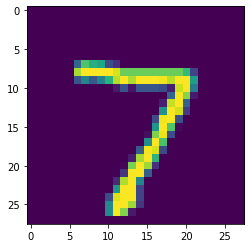

In [ ]:
batch_of_samples, labels = next(iter(test_dataloader))
plt.imshow(batch_of_samples[0].reshape(28,28))

# VAE

Variational autoencoders compress input information into a constrained multivariate latent distribution (encoding) to reconstruct it as accurately as possible (decoding).

**Aim** of VAE:
The framework of variational autoencoders (VAEs) ([Kingma and Welling, 2014](https://arxiv.org/abs/1312.6114); [Rezende et al., 2014]()) provides a principled method for jointly learning deep latent-variable models and corresponding inference models using stochastic gradient descent.

A variational autoencoder (VAE), rather than directly outputting values for the latent state as we would in a standard AE, provides a probabilistic manner for describing an observation in latent space.
It formulates the encoder to describe a probability distribution for each latent attribute.
During training we sample from these distributions to obtain a latent state for the decoder.




Traditional **VAEs make the strong assumption on the distribution of latent codes as a multivariate Gaussian with a diagonal covariance structure**, so each component is normally distributed and indipendent from the others.

A $n$-dimensional gaussian is defined by a vector $(\mu_1, ... , \mu_n)$ and a covariance matrix $\Sigma \in \mathbb{R}^{n \times n}$. Since we are assuming independent components, $\Sigma$ is a diagonal matrix and we can describe it with a single vector of size $n$ containing the diagonal.


The Encoder of a VAE outputs two vectors collecting the means and the variances (instead of encoding the variance $\sigma^2$ we will work for convenience with the logarithm of the variance $log(\sigma^2)$).


Let's suppose we've trained an autoencoder model on a large dataset of faces with a encoding dimension of 6. An ideal autoencoder will learn descriptive attributes of faces such as skin color, whether or not the person is wearing glasses, etc. in an attempt to describe an observation in some compressed representation.

Example
![image](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-16-at-10.24.11-PM.png)


In the example above, we've described the input image in terms of its latent attributes using a **single value to describe each attribute**.

However, we may prefer to represent each latent attribute as a range of possible values. Using a variational autoencoder, we can describe latent attributes in probabilistic terms.

![image](https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.47.56-PM.png)

With this approach, we'll now represent each latent attribute for a given input as a probability distribution. When decoding from the latent state, we'll randomly sample from each latent state distribution to generate a vector as input for our decoder model.


By constructing our encoder model to output a range of possible values (a statistical distribution) from which we'll randomly sample to feed into our decoder model, we're essentially enforcing a continuous, smooth latent space representation. For any sampling of the latent distributions, we're expecting our decoder model to be able to accurately reconstruct the input. Thus, values which are nearby to one another in latent space should correspond with very similar reconstructions.

![image](https://www.jeremyjordan.me/content/images/2018/06/Screen-Shot-2018-06-20-at-2.48.42-PM.png)

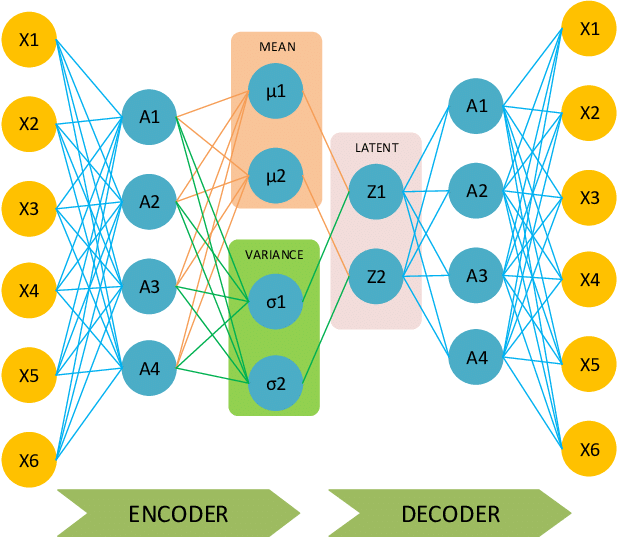

## Reparametrization Trick

We understand how these models work in theory, but for practical implementation we still have to fix something!

VAEs require to sample from the distribution predicted by the encoder to obtain a latent code for the decoder, but can't backpropagate gradients through sampling?



In order to backpropagate through a random node we use the reparametrization trick.


![imgae](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.36.34-PM.png)

![image](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-4.39.41-PM.png)



Other implementation tircks:  In order to deal with the fact that the network may learn negative values for σ
, we'll typically have the network learn logσ
 and exponentiate this value to get the latent distribution's variance.

## Loss function

We have to design a loss such that it reconstructs well based on the given images, but also learn the entire distribution and not overfit to only the image itself.
The loss function is therefore a combination of two terms:
1. Reconstruction loss term
2. KL divergence between posterior and likelihood probability.


As reconstruction loss we will use  Binary Cross Entropy (BCE) Loss. This calculates the pixel-to-pixel difference of the reconstructed image with the original image to maximise the similarity of reconstruction.

If $Q$ and $P$ are two gaussians distributions we have that
$$ D(Q||P)= log(\frac{\sigma_q}{\sigma_p})- \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{2(\sigma_p)^2} + 1/2$$.

For the derivation of the Kullback-Leibler Divergence in the case of Gaussian distributions see https://arxiv.org/pdf/1907.08956.pdf.

From the previous formula we derive that in case the prior distribution is a standard Gaussian distribution i.e. $ \mu_p=0, \sigma_p=1$ we have that
$$ D(Q||P)= \frac{1+ log(\sigma_q^2)- \sigma_q^2 - \mu_q^2}{2} $$


##Model: Encoder, Decoder, VAE

In [ ]:
class Encoder(pl.LightningModule):
    def __init__(self, hidden_channels: int, latent_dim: int, img_channels=1, image_size = 28) -> None:
        """
        Encoder module
        It takes as input an image and outputs mean and log(variance) parameters.

        """
        super().__init__()

        #define the following layers:

        self.conv1 = nn.Conv2d(in_channels=img_channels,
                               out_channels=hidden_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)

        self.out_conv1 = int(np.floor(image_size - 3 + 2*1)+1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=3,
                               stride=2,
                               padding=1 )
        self.out_conv2 = int(np.floor((self.out_conv1 - 3 + 2*1)/2)+1)
        self.activation = nn.ReLU()
        self.fc_mu = nn.Linear(in_features=hidden_channels*2*self.out_conv2*self.out_conv2 ,
                               out_features=latent_dim)
        self.fc_log_sigma = nn.Linear(
                               in_features=hidden_channels*2*self.out_conv2*self.out_conv2,
                               out_features=latent_dim)



    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        Input is fed into 2 convolutional layers sequentially
        The output feature map are fed into 2 fully-connected layers to predict mean (mu) and log of the variance (log_sigma)
        """

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0],-1)

        mu = self.fc_mu(x)
        log_sigma = self.fc_log_sigma(x)

        return mu, log_sigma

class Decoder(pl.LightningModule):
    def __init__(self, hidden_channels: int, latent_dim: int, img_channels=1, image_size =28 ) -> None:
        """
        Simple decoder module
        """
        super().__init__()
        self.out_conv1 = int(np.floor(image_size - 3 + 2*1)+1)
        self.out_conv2 = int(np.floor((self.out_conv1 - 3 + 2*1)/2)+1)
        self.hidden_channels = hidden_channels

        self.fc =   nn.Linear( in_features=latent_dim,
                              out_features= hidden_channels*2 *self.out_conv2*self.out_conv2)

        self.conv2 =  nn.ConvTranspose2d(
                            in_channels=hidden_channels*2,
                            out_channels=hidden_channels,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1)

        self.conv1 =  nn.ConvTranspose2d(
                            in_channels=hidden_channels,
                            out_channels=img_channels,
                            kernel_size=3,
                            stride=1,
                            padding=1)

        self.activation = nn.ReLU()


    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        z is fed back into a fully-connected layers and then into two transpose convolutional layers
        The generated output is the same size of the original input

        """
        z = self.activation(self.fc(z))
        z = z.view(z.size(0), self.hidden_channels*2, 14, 14)  # reshape the input so that it has the shape of an image
        z = self.activation(self.conv2(z))
        z = torch.sigmoid(self.conv1(z)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return z



class VAE(pl.LightningModule):
    def __init__(self, hidden_channels: int, latent_dim: int, enc_out_dim: int, img_channels=1, beta =1):
        super().__init__()
        self.enc_out_dim =  enc_out_dim
        self.encoder = Encoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim, img_channels=img_channels)
        self.decoder = Decoder(hidden_channels=hidden_channels,
                               latent_dim=latent_dim,img_channels=img_channels)
        self.beta = beta


    def loss_function(recon_x, x, mu, log_sigma, beta):
        recon_loss = F.binary_cross_entropy(recon_x.view(-1,784), x.view(-1,784),  reduction='sum')
        #recon_loss = nn.MSELoss()(recon_x, x)
        KLdiv = -0.5 *torch.sum( 1 + log_sigma - log_sigma.exp() - mu**2 )
        return recon_loss + beta *  KLdiv


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x: torch.Tensor) :
        mu, log_sigma  = self.encoder(x)
        std = torch.exp((log_sigma)*0.5)
        epsilon = torch.normal(torch.zeros_like(std), torch.ones_like(std))
        z = mu + epsilon*std
        x_hat = self.decoder(z)
        return x


    def training_step(self, batch, batch_idx):
        x, _ = batch
        # encode x to get the mu and variance parameters
        mu, log_sigma  = self.encoder(x)
        # we implement the reparametrization trick: sample z
        # Compute the standard deviation
        std = torch.exp((log_sigma)*0.5)
        # Define epsilon
        epsilon = torch.normal(torch.zeros_like(std), torch.ones_like(std))
        # Compute z
        z = mu + epsilon*std
        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_hat.view(-1,784), x.view(-1,784),  reduction='sum')
        # kl
        kl =  -0.5 *torch.sum( 1 + log_sigma - log_sigma.exp() - mu**2 )

        # elbo
        elbo =  recon_loss + beta * kl

        self.log_dict({
            'train_loss': elbo,
        })
        return elbo


    def validation_step(self, batch, batch_idx):
        x, _ = batch
        mu, log_sigma  = self.encoder(x)
        std = torch.exp((log_sigma)*0.5)
        epsilon = torch.normal(torch.zeros_like(std), torch.ones_like(std))
        z = mu + epsilon*std
        x_hat = self.decoder(z)
        recon_loss = F.binary_cross_entropy(x_hat.view(-1,784), x.view(-1,784),  reduction='sum')
        loss =  recon_loss
        self.log_dict({
            'val_loss': loss,
        })
        return loss



In [ ]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)

pl.seed_everything(1234)
latent_dims = 2
batch_size = 128
hidden_channels=64
learning_rate = 1e-3
beta = 1
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")



vae = VAE(hidden_channels=hidden_channels, latent_dim=latent_dims, enc_out_dim=14)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters of the model: %d' % num_params)

trainer = pl.Trainer(gpus=1, max_epochs=50)
trainer.fit(vae, train_dataloader )


INFO:lightning_lite.utilities.seed:Global seed set to 1234
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightni

Number of parameters of the model: 324485


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Simple schematic of computational flow in a variational autoencoder.



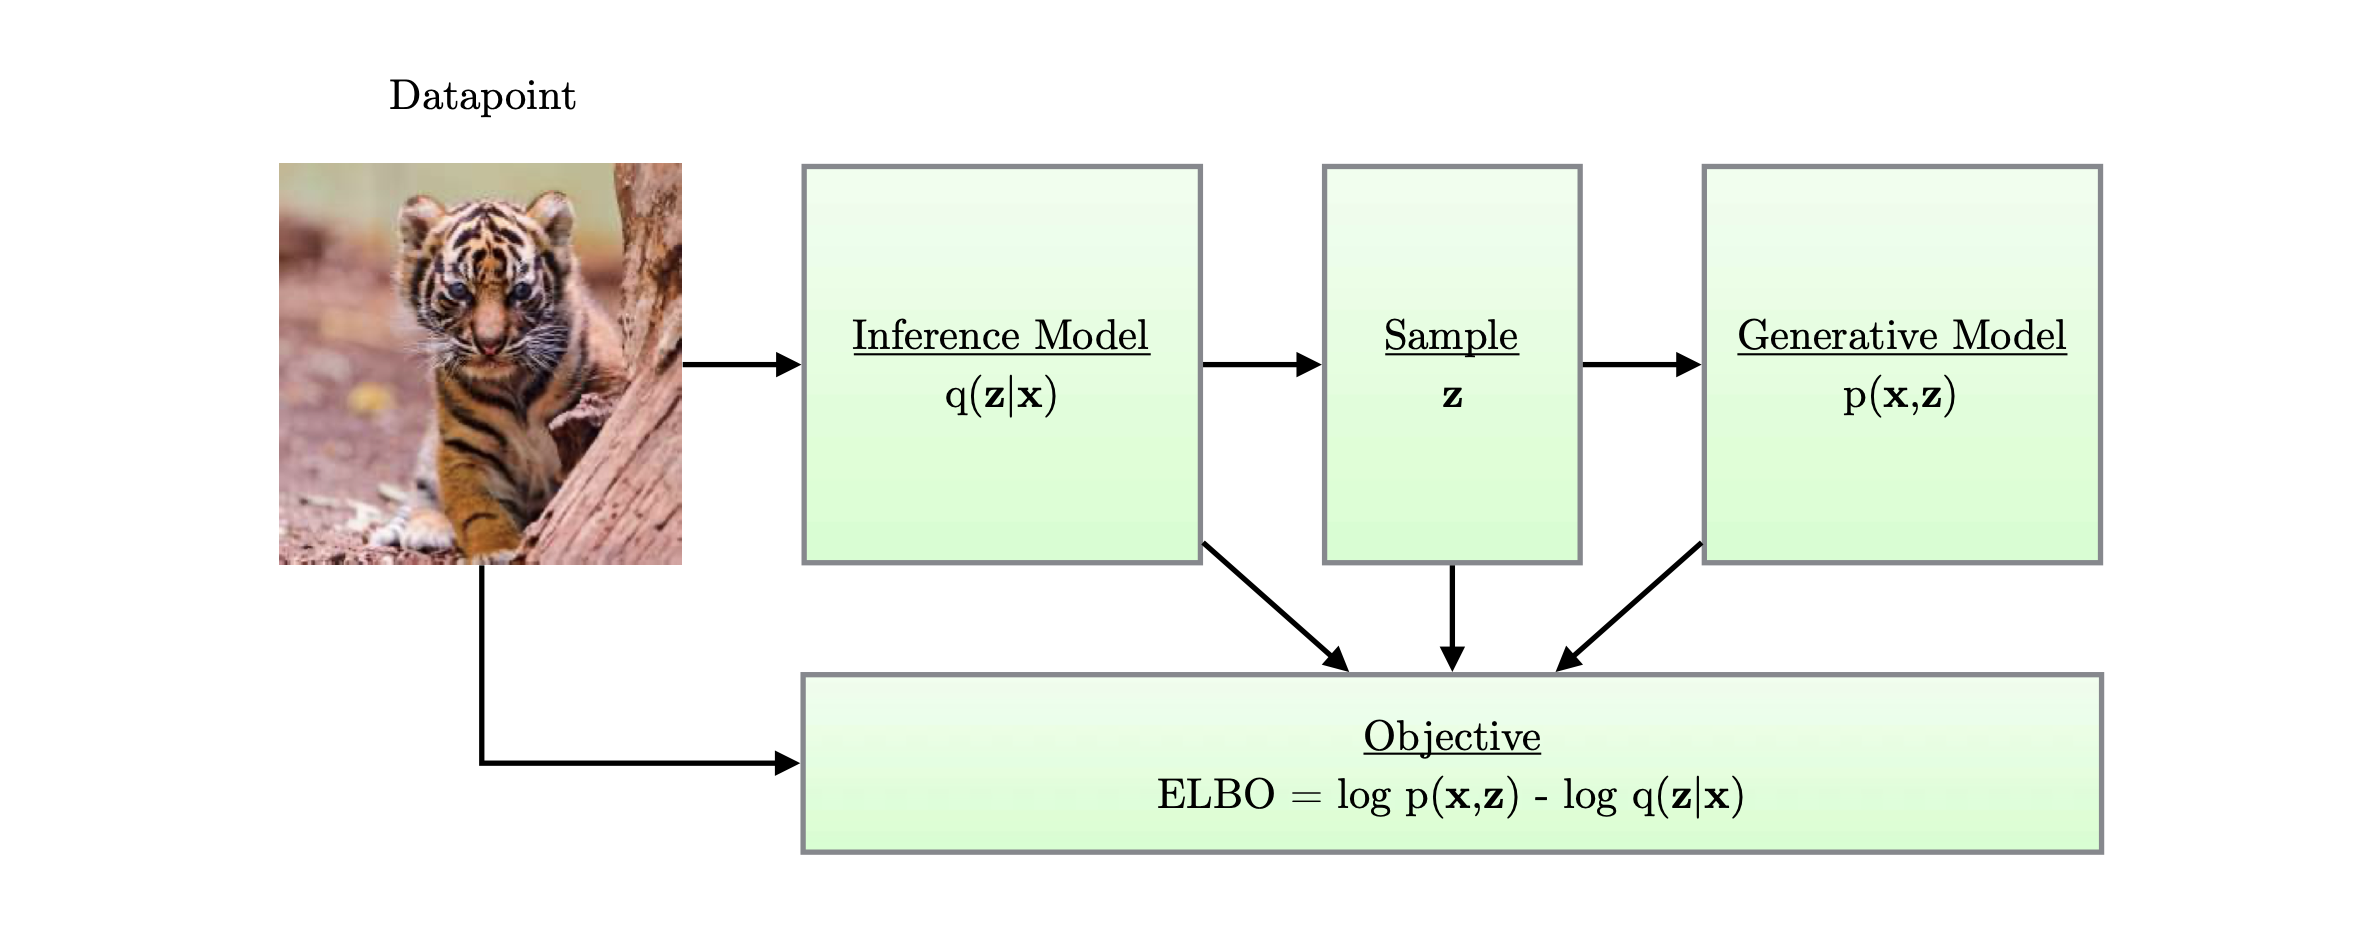

## Visualization

**Visualization Functions**

The VisualizeReconstruction function randomly chooses two images for each digit of the MNIST data set, passes them through the VAE, and plots the reconstruction side by side with the original input. Note that to plot the information contained inside a dlarray object, you need to extract it first using the extractdata and gather functions.

Now we build a dictionary that will be useful later.
The keys of the dictionary are the labels of MNIST, i.e. {0,1,2,3,...,9}
The value assigned to a key are the images of the test_dataloader that has as label the key.

Namely `image_dict[0]` will be the list of all  handwritten 0  images contained in the `test_dataloader`



In [ ]:
image_dict = {}
for i in range(10):
  image_dict[i] =[]
for images, labels in test_dataloader:
    for i in range(images.shape[0]):
      image_dict[labels[i].item()].append(images[[i]])


The following function take as input an image (or a batch of images) and a autoencoder model, performs a forward pass and gives as output the reconstructed image (imgaes).

In [ ]:
def reconstruct_images(images, model):
    model.eval()
    with torch.no_grad():
        images = model(images)
        images = images.clamp(0, 1)
        return images


We'd like to see how good is our model to reconstruct images.



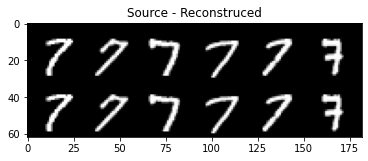

In [ ]:
digit = 7 #@param {type:"slider", min:0, max:9, step:1}
images_number = 6  #@param {type:"slider", min:0, max:9, step:1}

# choose randomly one of the images in the images dictionary that corresponds to that label

style = torch.randint(0, len(image_dict[digit]),(images_number,))
list_tensors = torch.cat([image_dict[digit][index] for index in style])
all_images = torch.cat((list_tensors, reconstruct_images(list_tensors,vae).cpu()))

#all_images = torch.cat((list_tensors,
#                        reconstruct_images(list_tensors,vae).cpu(),
#                        reconstruct_images(list_tensors,vae_zero_beta).cpu(),
#                        reconstruct_images(list_tensors,vae_great_beta).cpu(),
#                        ))

plt.imshow(torchvision.utils.make_grid(all_images, images_number).permute(1, 2, 0))
plt.title("Source - Reconstruced")

def show_image(img):
    img = img.clamp(0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



# sample latent vectors from the normal distribution
latent = torch.randn(128, latent_dims, device=device)
plt.show()

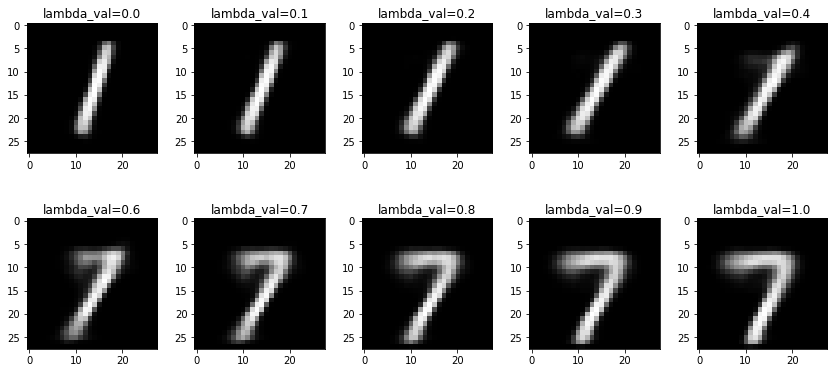

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1
        latent_1, _= model.encoder(img1)

        # latent vector of second image
        img2 = img2
        latent_2, _= model.encoder(img2)


        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = inter_image.clamp(0,1)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

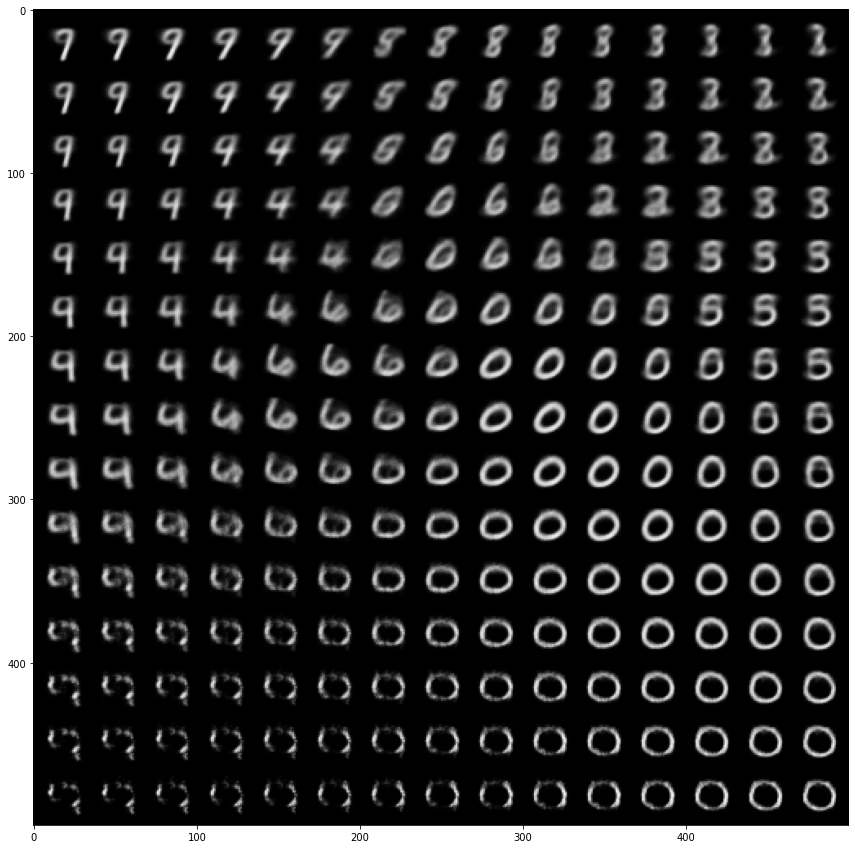

In [ ]:
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,15)
    latent_y = np.linspace(-1.5,1.5,15)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(15,15))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],15,5))
    plt.show()

### VAE Interpolation vs Euclidean Interpolation

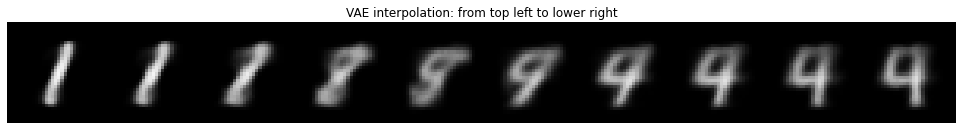

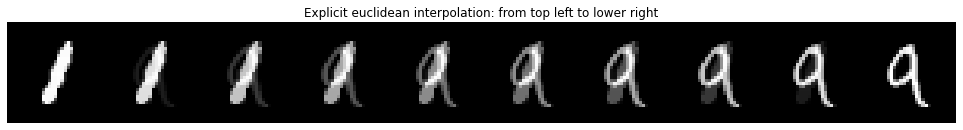

In [ ]:
# VAE Interpolation vs Euclidean Interpolation

def euclidean_interpolation(lambda1, img1, img2):

    with torch.no_grad():

        # explicit interpolation of the images
        inter_image = (1 - lambda1) * img1 + lambda1 * img2

        # reconstruct interpolated image
        inter_image = inter_image.clamp(0, 1).cpu()

        return inter_image

vae.eval()


num_interpolations = 10 #@param {type:"slider", min:10, max:100, step:10}

start_digit = 1 #@param {type:"slider", min:0, max:9, step:1}
end_digit = 9 #@param {type:"slider", min:0, max:9, step:1}
style = 16 #@param {type:"slider", min:0, max:42, step:1}

#style = torch.randint(0, len(image_dict[start_digit]),(1,))

start_image = image_dict[start_digit][style]
end_image = image_dict[end_digit][style]

# interpolation lambdas
lambda_range=np.linspace(0,1,num_interpolations)
bigimage = torch.cat([interpolation(x, vae, end_image, start_image) for x in lambda_range])
bigimage_euclidean = torch.cat([euclidean_interpolation(x, start_image, end_image) for x in lambda_range])



# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage, 10).permute(1, 2, 0))
plt.title("VAE interpolation: from top left to lower right")
plt.axis('off')
plt.show()

# Matplolib plot, much faster for static images
plt.figure(figsize = (17, 17))
plt.imshow(torchvision.utils.make_grid(bigimage_euclidean, 10).permute(1, 2, 0))
plt.title("Explicit euclidean interpolation: from top left to lower right")
plt.axis('off')
plt.show()

<ipython-input-41-1c419ee24998>:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  z_sigma = (z_log_sigma // 2 ).exp().squeeze().cpu().detach().numpy()


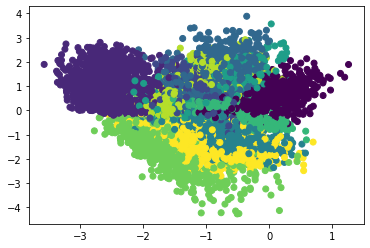

In [ ]:

def visualizeLatentSpace(test_images, test_labels,model):
    z_mu, z_log_sigma = model.encoder(test_images)
    z_sigma = (z_log_sigma // 2 ).exp().squeeze().cpu().detach().numpy()
    z_mu = z_mu.squeeze().cpu().detach().numpy()
    c = np.arange(10)
    plt.scatter(z_mu[:,1],z_mu[:,0],c =test_labels.tolist())

a =next(iter(test_dataloader))
visualizeLatentSpace(a[0], a[1],vae)


## Using Lighting Bolt


We need to install pytorch lighting.
We can also try [Ligthing Bolt](https://www.pytorchlightning.ai/bolts) to load our models.

![image] (https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-7.22.24-PM.png)

**EXERCISE**

Write a  `validation_step` function for the VAE_litghtining model and test you model!

Sources :
[original paper](https://arxiv.org/pdf/1312.6114.pdf)

[notes from authors](https://arxiv.org/pdf/1906.02691.pdf)

[this blog](https://www.jeremyjordan.me/variational-autoencoders/ ) for images

[this notebook](https://colab.research.google.com/github/lucmos/DLAI-s2-2020-tutorials/blob/master/08/8_Variational_Autoencoders_(VAEs).ipynb)

[this page]( https://www.mathworks.com/help/deeplearning/ug/train-a-variational-autoencoder-vae-to-generate-images.html#GeneratingHanddrawnDigitsUsingAVariationalAutoencoderVAEExample-12)

[this post](https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368)

[this notebook](https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing#scrollTo=Eg5bOMsDHGUj)

